# Uso de Transfer Learning para aprendizado em Redes Neurais Convolucionais (CNNs)
Este projeto explora o uso da técnica *Transfer Learning* aplicado a redes neurais convolucionais. Investigo como modelos pré-treinados em conjuntos de dados massivos podem ser adaptados para tarefas específicas com conjuntos de dados menores.

Além disso, examinaremos os benefícios do Transfer Learning em termos de eficiência computacional, treinamento mais rápido e melhor generalização para novos dados.

## O que é Transfer Learning?
O campo de aprendizado de máquina tem experimentado avanços notáveis, especialmente no domínio de visão computacional, onde as redes neurais convolucionais (CNNs) desempenham um papel fundamental. No entanto, treinar modelos de CNNs a partir do zero para tarefas específicas pode ser desafiador e exigir grandes volumes de dados.

Uma abordagem eficaz para contornar esse desafio é o uso de Transfer Learning, uma técnica que permite a **reutilização de conhecimentos adquiridos** em uma tarefa para melhorar o desempenho em outra. Transfer Learning demonstrou ser particularmente eficaz em contextos onde os conjuntos de dados são limitados.

## Baixando bibliotecas necessárias

In [6]:
%matplotlib inline

import os
import zipfile

# Se você quiser baixar os modelos utilizando o Colab
#from google.colab import files

# Se estiver utilizando o Theano com GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import cv2
import keras
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import keras.utils as image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model, load_model

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

## Baixando dataset alvo e tratamento de imagens obtidas
O dataset escolhido para ser analisado neste projeto é o [Cats vs. Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=pt-br), disponibilizado pelo TensorFlow.

Se você pensou que é um dataset de fotos de cães e gatos... bom, você acertou. Nele há 25 mil imagens igualmente distribuídas entre as duas classes, sendo 0 se referindo a gatos e 1 a cães.

Cabe a observação de que, algumas imagens não estavam sendo carregadas corretamente, logo, foram descartadas da análise.

In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Exclusão o arquivo zip
os.remove(local_zip)

--2023-12-31 13:16:19--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.123.44.196, 2a02:26f0:9400:1ba::317f, 2a02:26f0:9400:19b::317f
Connecting to download.microsoft.com (download.microsoft.com)|104.123.44.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  21.2MB/s    in 8.1s    

2023-12-31 13:16:27 (97.1 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [ ]:
# Checando integridade das pastas
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Saída esperada:
# 12501
# 12501

12501
12501


In [ ]:
# Carregando todas as imagens para o ambiente com numpy arrays
def load_and_preprocess_images(directory, target_size=(150, 150)):
    images = []
    labels = []

    for class_label, class_name in enumerate(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)

        for filename in tqdm(os.listdir(class_path), desc=f"Loading {class_name} images"):
            file_path = os.path.join(class_path, filename)

            # Lê a imagem e redimensiona para o tamanho desejado
            image = cv2.imread(file_path)

            if image is None:
                print(f"Erro ao ler a imagem: {file_path}")
                continue

            image = cv2.resize(image, target_size)

            # Adiciona a imagem e rótulo às listas
            images.append(image)
            labels.append(class_label)

    return np.array(images), np.array(labels)

IMAGES_DIR = "/tmp/PetImages/"
all_images, all_labels = load_and_preprocess_images(IMAGES_DIR)

Loading Cat images:   3%|▎         | 347/12501 [00:01<00:37, 323.76it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/4833.jpg


Loading Cat images:   4%|▎         | 446/12501 [00:01<00:37, 325.49it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/Thumbs.db
Erro ao ler a imagem: /tmp/PetImages/Cat/2663.jpg


Loading Cat images:   8%|▊         | 982/12501 [00:03<00:35, 324.03it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/3491.jpg


Loading Cat images:  10%|█         | 1301/12501 [00:04<00:33, 337.87it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/11935.jpg


Loading Cat images:  20%|██        | 2503/12501 [00:08<00:40, 246.63it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/660.jpg


Loading Cat images:  21%|██        | 2582/12501 [00:08<00:38, 255.71it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/850.jpg


Loading Cat images:  26%|██▋       | 3305/12501 [00:10<00:24, 373.31it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/140.jpg


Loading Cat images:  27%|██▋       | 3385/12501 [00:10<00:23, 386.34it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/7968.jpg


Loading Cat images:  30%|██▉       | 3703/12501 [00:11<00:22, 383.19it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/936.jpg


Loading Cat images:  32%|███▏      | 4052/12501 [00:12<00:21, 385.77it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/9171.jpg


Loading Cat images:  36%|███▌      | 4463/12501 [00:13<00:19, 421.76it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/10404.jpg


Loading Cat images:  39%|███▉      | 4932/12501 [00:14<00:18, 407.58it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/11565.jpg


Loading Cat images:  42%|████▏     | 5223/12501 [00:15<00:17, 406.46it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/7978.jpg


Loading Cat images:  56%|█████▌    | 6992/12501 [00:20<00:19, 288.07it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/11210.jpg


Loading Cat images:  58%|█████▊    | 7221/12501 [00:20<00:19, 276.33it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/5553.jpg
Erro ao ler a imagem: /tmp/PetImages/Cat/10820.jpg


Loading Cat images:  58%|█████▊    | 7310/12501 [00:21<00:18, 280.15it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/3300.jpg


Loading Cat images:  67%|██████▋   | 8346/12501 [00:23<00:09, 430.41it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/9565.jpg


Loading Cat images:  69%|██████▊   | 8574/12501 [00:24<00:09, 417.25it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/10501.jpg


Loading Cat images:  80%|███████▉  | 9992/12501 [00:27<00:05, 459.37it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/8470.jpg


Loading Cat images:  82%|████████▏ | 10232/12501 [00:27<00:04, 464.41it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/666.jpg


Loading Cat images:  92%|█████████▏| 11458/12501 [00:30<00:02, 463.79it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/9778.jpg


Loading Cat images:  93%|█████████▎| 11597/12501 [00:31<00:02, 435.07it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/11874.jpg


Loading Cat images:  99%|█████████▊| 12327/12501 [00:33<00:00, 275.13it/s]

Erro ao ler a imagem: /tmp/PetImages/Cat/10125.jpg


Loading Dog images:   4%|▎         | 462/12501 [00:01<00:40, 298.69it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/Thumbs.db


Loading Dog images:   8%|▊         | 1057/12501 [00:03<00:38, 295.81it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/9188.jpg


Loading Dog images:  10%|▉         | 1190/12501 [00:04<00:36, 311.39it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/6718.jpg
Erro ao ler a imagem: /tmp/PetImages/Dog/10401.jpg
Erro ao ler a imagem: /tmp/PetImages/Dog/2688.jpg


Loading Dog images:  13%|█▎        | 1672/12501 [00:05<00:34, 311.91it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/1866.jpg


Loading Dog images:  15%|█▌        | 1908/12501 [00:06<00:32, 328.79it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/11675.jpg


Loading Dog images:  17%|█▋        | 2080/12501 [00:06<00:30, 337.53it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/4367.jpg


Loading Dog images:  22%|██▏       | 2721/12501 [00:08<00:28, 343.38it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/1308.jpg
Erro ao ler a imagem: /tmp/PetImages/Dog/3136.jpg


Loading Dog images:  23%|██▎       | 2827/12501 [00:09<00:28, 336.23it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/11853.jpg


Loading Dog images:  27%|██▋       | 3427/12501 [00:11<00:36, 247.80it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/11410.jpg


Loading Dog images:  31%|███       | 3881/12501 [00:13<00:35, 244.60it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/6238.jpg


Loading Dog images:  35%|███▍      | 4331/12501 [00:14<00:21, 372.51it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/7133.jpg


Loading Dog images:  35%|███▌      | 4408/12501 [00:14<00:21, 373.87it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/3588.jpg


Loading Dog images:  37%|███▋      | 4669/12501 [00:15<00:21, 362.34it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/10747.jpg


Loading Dog images:  40%|███▉      | 4988/12501 [00:16<00:19, 394.66it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/7459.jpg


Loading Dog images:  44%|████▍     | 5505/12501 [00:17<00:18, 384.02it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/8730.jpg
Erro ao ler a imagem: /tmp/PetImages/Dog/11849.jpg


Loading Dog images:  61%|██████    | 7617/12501 [00:22<00:12, 398.18it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/7969.jpg


Loading Dog images:  62%|██████▏   | 7699/12501 [00:22<00:11, 400.92it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/3288.jpg
Erro ao ler a imagem: /tmp/PetImages/Dog/11702.jpg


Loading Dog images:  68%|██████▊   | 8454/12501 [00:25<00:15, 261.67it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/7112.jpg


Loading Dog images:  74%|███████▎  | 9207/12501 [00:27<00:07, 450.67it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/7369.jpg


Loading Dog images:  77%|███████▋  | 9593/12501 [00:28<00:09, 298.19it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/5736.jpg


Loading Dog images:  81%|████████  | 10097/12501 [00:30<00:05, 405.40it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/2877.jpg


Loading Dog images:  85%|████████▌ | 10640/12501 [00:31<00:04, 443.62it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/5604.jpg


Loading Dog images:  87%|████████▋ | 10911/12501 [00:32<00:05, 278.63it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/10158.jpg


Loading Dog images:  91%|█████████ | 11357/12501 [00:33<00:03, 317.22it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/10797.jpg


Loading Dog images:  92%|█████████▏| 11451/12501 [00:34<00:03, 283.16it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/2384.jpg


Loading Dog images:  95%|█████████▌| 11896/12501 [00:36<00:02, 271.36it/s]

Erro ao ler a imagem: /tmp/PetImages/Dog/6059.jpg


Loading Dog images: 100%|██████████| 12501/12501 [00:39<00:00, 317.62it/s]


## Separação dos diferentes conjuntos de dados

In [ ]:
# 20% de imagens são destinadas ao conjunto de teste
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# 15% das imagens do conjunto de teste são destinadas ao conjunto de validação.
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.15, random_state=42)

In [ ]:
# Verificação de distribuição de dados nos conjuntos criados

# Criar um DataFrame para facilitar a análise
df_train = pd.DataFrame({'label': train_labels, 'set': 'train'})
df_val = pd.DataFrame({'label': val_labels, 'set': 'validation'})
df_test = pd.DataFrame({'label': test_labels, 'set': 'test'})

# Concatenar os DataFrames
df = pd.concat([df_train, df_val, df_test])

# Calcular o tamanho de cada conjunto por label
sizes_by_label = df.groupby(['set', 'label']).size().unstack()

print("Tamanho de cada conjunto por label:")
print(sizes_by_label)

Tamanho de cada conjunto por label:
label          0     1
set                   
test        2547  2443
train       8439  8523
validation  1490  1504


## Criação da modelo em formato de rede neural convolucional
Note que, o modelo abaixo criado será treinado sem possuir nenhum tipo de conhecimento prévio sobre classificação de imagens.

Perceba também que há diversas maneiras de customizá-lo e melhorá-lo, porém, não é o objetivo desta análise.

In [ ]:
# Criação e compilação do modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 64)       

In [ ]:
# Checando se, as imagens nos conjuntos possuem o shape inserido na entrada do modelo.
expected_shape = (150,150,3)
if train_images[0].shape == val_images[0].shape and val_images[0].shape == test_images[0].shape:
  print(f"Imagens com formato correto.")
else:
  print(f"Erro no formato de imagens.")

Imagens com formato correto.


## Treinamento e análise de resultados do modelo criado

In [ ]:
#Treinamento do modelo sem transfer learning
history = model.fit(
    train_images, train_labels,
    epochs=20,
    validation_data=(val_images, val_labels)
)

Epoch 1/20
531/531 [==============================] - 10s 15ms/step - loss: 3.9512 - acc: 0.6018 - val_loss: 0.5913 - val_acc: 0.6750
Epoch 2/20
531/531 [==============================] - 7s 13ms/step - loss: 0.5806 - acc: 0.7066 - val_loss: 0.6644 - val_acc: 0.6313
Epoch 3/20
531/531 [==============================] - 7s 14ms/step - loss: 0.4896 - acc: 0.7735 - val_loss: 0.4856 - val_acc: 0.7789
Epoch 4/20
531/531 [==============================] - 7s 14ms/step - loss: 0.4092 - acc: 0.8171 - val_loss: 0.7399 - val_acc: 0.7371
Epoch 5/20
531/531 [==============================] - 7s 14ms/step - loss: 0.3249 - acc: 0.8628 - val_loss: 0.8017 - val_acc: 0.7679
Epoch 6/20
531/531 [==============================] - 8s 16ms/step - loss: 0.2484 - acc: 0.9035 - val_loss: 0.6894 - val_acc: 0.7091
Epoch 7/20
531/531 [==============================] - 7s 14ms/step - loss: 0.1833 - acc: 0.9318 - val_loss: 0.8885 - val_acc: 0.8023
Epoch 8/20
531/531 [==============================] - 8s 14ms/step -

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print("Acurácia no conjunto de teste: {:.2f}".format(test_accuracy))

156/156 [==============================] - 1s 7ms/step - loss: 3.2520 - acc: 0.7978
Acurácia no conjunto de teste: 0.80


Será que a acurácia no conjunto de teste é de fato a melhor/única maneira de avaliar se nosso modelo está realmente indo bem?

Bom, depende das suas considerações sobre o tema.

Para este projeto, eu considero que isso é **insuficiente**, então abaixo você pode ver como estãos dispostos os valores de acurácia e perda (*loss*) durante as épocas nos conjutnos de treino e validação.

Isso pode nos ajudar e entender como o modelo aprendeu (ou não) ao longo do tempo.

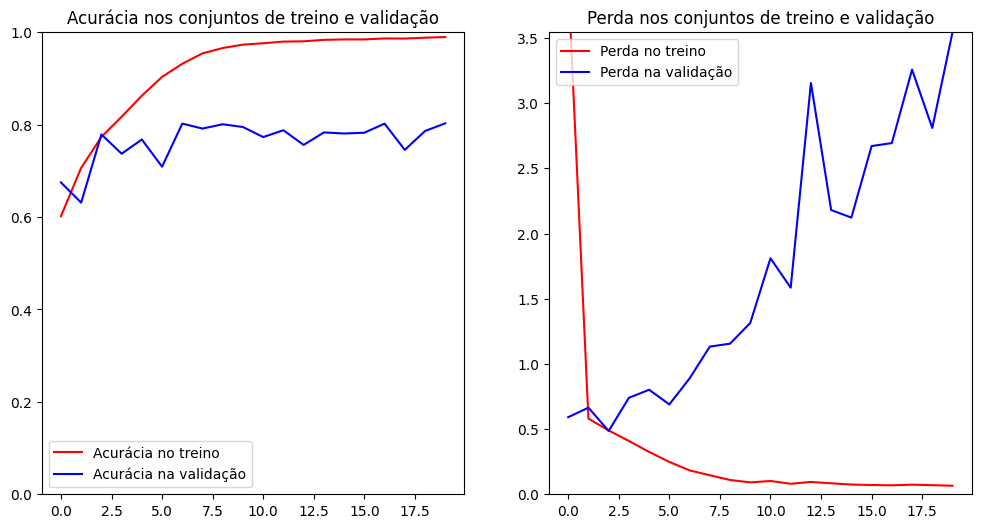

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 6))

# Plot de treinamento
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label="Acurácia no treino")
plt.plot(epochs, val_acc, 'b', label="Acurácia na validação")
plt.title('Acurácia nos conjuntos de treino e validação')
plt.legend()
plt.ylim(0, 1)  # Definir os limites do eixo y entre 0 e 1

# Plot de perda
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label="Perda no treino")
plt.plot(epochs, val_loss, 'b', label="Perda na validação")
plt.title('Perda nos conjuntos de treino e validação')
plt.legend()

#Esta perda será utilizada em análise futura
val_loss_m1 = max(val_loss)
plt.ylim(0, max(val_loss))

plt.show()

O conjunto de validação desempenha um papel crucial durante o treinamento de modelos de aprendizado de máquina, incluindo redes neurais convolucionais (CNNs).

Ao analisar o gráfico de acurácia, percebe-se uma discrepância entre a acurácia no conjunto de treinamento e a acurácia na validação. Essa disparidade sugere a possibilidade de *overfitting*, indicando que o modelo pode estar aprendendo detalhes específicos do conjunto de treinamento que não se traduzem efetivamente para dados não familiares. Em outras palavras, o modelo pode estar memorizando informações em vez de generalizar para cenários mais amplos. Essa observação destaca a necessidade de avaliar e ajustar o modelo para garantir uma melhor capacidade de generalização.

Da mesma maneira, o gráfico de perda escancara esta discrepância, mostrando que conforme as épocas vão passando os resultados estão cada vez mais distantes do ideal (que seria 0).

## Baixando rede pré-treinada
A rede escolhida para esta análise é a [*VGG16*](https://keras.io/api/applications/vgg/), usando os pesos pré-treinados com base no dataset *imagenet*.

A rede possui diversas camadas que variam entre pooling e convoluções, aceitando uma entrada inicial no formato 224x224x3.

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## Começando o transfer learning
A ideia aqui é conseguir utilizar de algum jeito o conhecimento que essa rede já possui, porém, focando no nosso objetivo inicial: classificar corretamente cães e gatos.

Para realizar isso, '*congelamos*' os pesos da rede, deixando duas camadas adicionadas ao final.

Estas camadas terão seus pesos treináveis e servirão para o modelo aprender e definir quais são as características que ajudam de fato a conseguir discernir entre as duas classes oferecidas.

In [ ]:
# Congelamento todas as camadas da VGG16
for layer in vgg.layers:
    layer.trainable = False

# Adição de uma nova camada de pooling global e uma camada densa para a classificação binária
x = GlobalAveragePooling2D()(vgg.output)
predictions = Dense(1, activation='sigmoid')(x)

# Criação o novo modelo combinando a VGG16 e a nova camada
model_new = Model(inputs=vgg.input, outputs=predictions)

# Garantia de que a última camada é treinável
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model_new.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

## Treinamento e análise de resultados do novo modelo

In [ ]:
history2 = model_new.fit(
    train_images, train_labels,
    epochs=20,
    validation_data=(val_images, val_labels)
)

Epoch 1/20
531/531 [==============================] - 46s 84ms/step - loss: 0.4524 - accuracy: 0.9262 - val_loss: 0.2101 - val_accuracy: 0.9566
Epoch 2/20
531/531 [==============================] - 39s 74ms/step - loss: 0.2210 - accuracy: 0.9519 - val_loss: 0.1671 - val_accuracy: 0.9626
Epoch 3/20
531/531 [==============================] - 45s 84ms/step - loss: 0.1746 - accuracy: 0.9583 - val_loss: 0.1799 - val_accuracy: 0.9586
Epoch 4/20
531/531 [==============================] - 45s 85ms/step - loss: 0.1485 - accuracy: 0.9610 - val_loss: 0.1369 - val_accuracy: 0.9626
Epoch 5/20
531/531 [==============================] - 41s 78ms/step - loss: 0.1352 - accuracy: 0.9633 - val_loss: 0.1449 - val_accuracy: 0.9626
Epoch 6/20
531/531 [==============================] - 47s 88ms/step - loss: 0.1311 - accuracy: 0.9626 - val_loss: 0.2984 - val_accuracy: 0.9332
Epoch 7/20
531/531 [==============================] - 46s 87ms/step - loss: 0.1216 - accuracy: 0.9639 - val_loss: 0.1708 - val_accuracy:

In [ ]:
test_loss, test_accuracy = model_new.evaluate(test_images, test_labels)

print("Acurácia no conjunto de teste: {:.2f}".format(test_accuracy))

156/156 [==============================] - 14s 88ms/step - loss: 0.1468 - accuracy: 0.9589
Acurácia no conjunto de teste: 0.96


Novamente, a acurácia não deveria ser a única métrica analisada, no entanto, já é perceptível que, com tempo de treinamento semelhante e mesmo número de épocas a acurácia já aumentou consideravelmente.

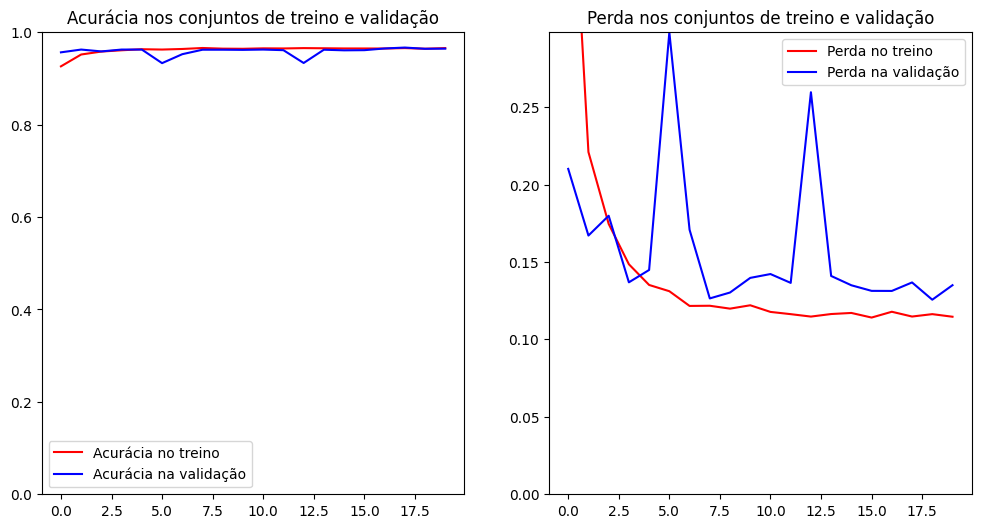

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 6))

# Plot de treinamento
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label="Acurácia no treino")
plt.plot(epochs, val_acc, 'b', label="Acurácia na validação")
plt.title('Acurácia nos conjuntos de treino e validação')
plt.legend()
plt.ylim(0, 1)  # Definir os limites do eixo y entre 0 e 1

# Plot de perda
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label="Perda no treino")
plt.plot(epochs, val_loss, 'b', label="Perda na validação")
plt.title('Perda nos conjuntos de treino e validação')
plt.legend()
plt.ylim(0, max(val_loss))

plt.show()

A função de perda exibiu algumas flutuações ao longo do treinamento; no entanto, é evidente que as métricas "coincidiram" de maneira mais consistente, exibindo resultados semelhantes durante toda a fase de treinamento.

## Comparando resultados entre modelos

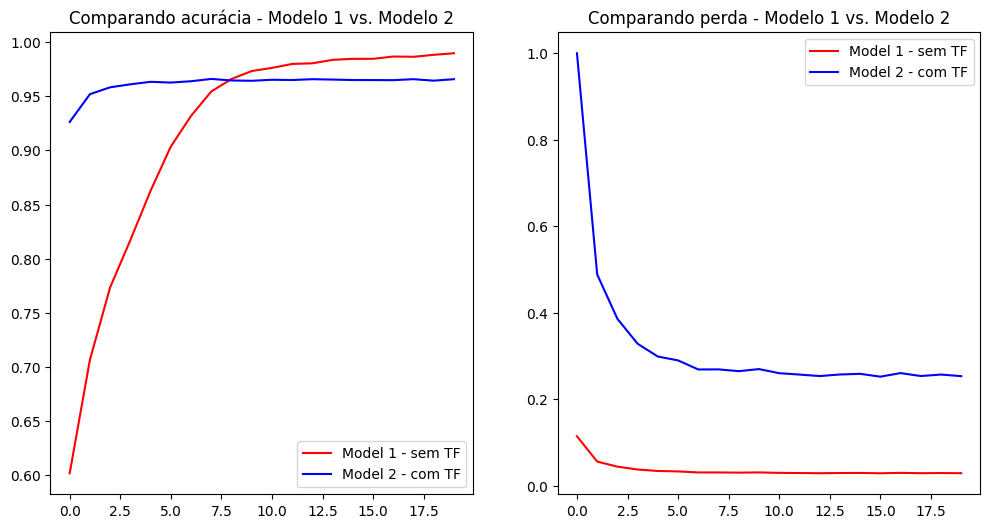

In [ ]:
acc1 = history.history['acc']
acc2 = history2.history['accuracy']
loss1 = history.history['loss']
loss2 = history2.history['loss']

# Normalizando os valores de perda para o intervalo [0, 1]
normalized_loss1 = [val / max(loss1 + loss2) for val in loss]
normalized_loss2 = [val / max(loss + loss2) for val in loss2]

epochs = range(len(acc))

plt.figure(figsize=(12, 6))

# Plot de treinamento
plt.subplot(1, 2, 1)
plt.plot(epochs, acc1, 'r', label="Modelo 1 - sem TF")
plt.plot(epochs, acc2, 'b', label="Modelo 2 - com TF")
plt.title('Comparando acurácia - Modelo 1 vs. Modelo 2')
plt.legend()

# Plot de perda
plt.subplot(1, 2, 2)
plt.plot(epochs, normalized_loss1, 'r', label="Modelo 1 - sem TF")
plt.plot(epochs, normalized_loss2, 'b', label="Modelo 2 - com TF")
plt.title('Comparando perda - Modelo 1 vs. Modelo 2')
plt.legend()

plt.show()

Nos gráficos acima apresentados é possível que haja a seguinte dúvida: "Se o modelo com transfer learning apresentou um resultado melhor, como ai ele parece que foi pior".

Note que aqui, estamos vendo a acurácia e perda dos modelos nos conjuntos de treinamento, porém, como consideramos previamente que o 1° modelo pode ter sofrido com 'overfitting" fazer essa comparação é um tanto ingênua.

Há uma maneira um pouco melhor: Curva ROC e valores AUC.

Curva ROC (Receiver Operating Characteristic):

A Curva ROC (Receiver Operating Characteristic) é um gráfico que representa a taxa de verdadeiros positivos (sensibilidade) em relação à taxa de falsos positivos (1 - especificidade) para diferentes pontos de corte em um modelo de classificação.
A curva ilustra o equilíbrio entre a sensibilidade e a especificidade do modelo em diferentes limiares de decisão.
Quanto mais próxima a curva ROC estiver do canto superior esquerdo, melhor é o desempenho do modelo.

A AUC (Area Under Curve) é a área sob a curva ROC e fornece uma medida agregada do desempenho do modelo em todos os limiares de decisão possíveis.
Se a AUC for 0.5, indica que o modelo é essencialmente aleatório.
AUC acima de 0.5 sugere que o modelo é melhor do que aleatório, sendo 1 o valor máximo alcançável.

In [ ]:
def plot_auc(model, tf):
  predictions = model.predict(test_images)

  # Cálculo da curva ROC
  fpr, tpr, thresholds = roc_curve(test_labels, predictions)

  # Cálculo a área sob a curva ROC (AUC)
  roc_auc = auc(fpr, tpr)

  # Plotar a curva ROC
  plt.figure(figsize=(8, 8))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de Falso Positivo')
  plt.ylabel('Taxa de Verdadeiro Positivo')

  if tf == True:
    plt.title('Curva ROC do modelo sem TF')
  else:
    plt.title('Curva ROC do modelo com TF')

  plt.legend(loc="lower right")
  plt.show()

156/156 [==============================] - 1s 4ms/step


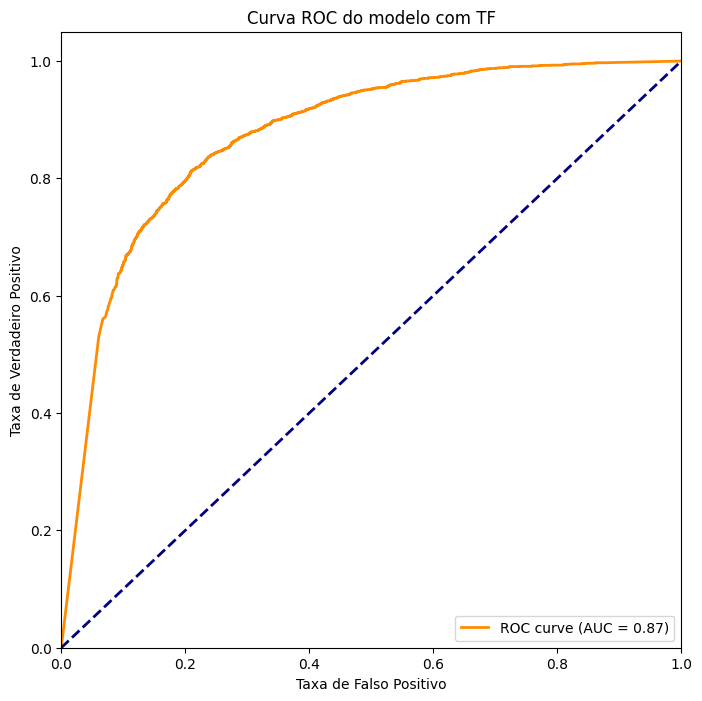

156/156 [==============================] - 10s 65ms/step


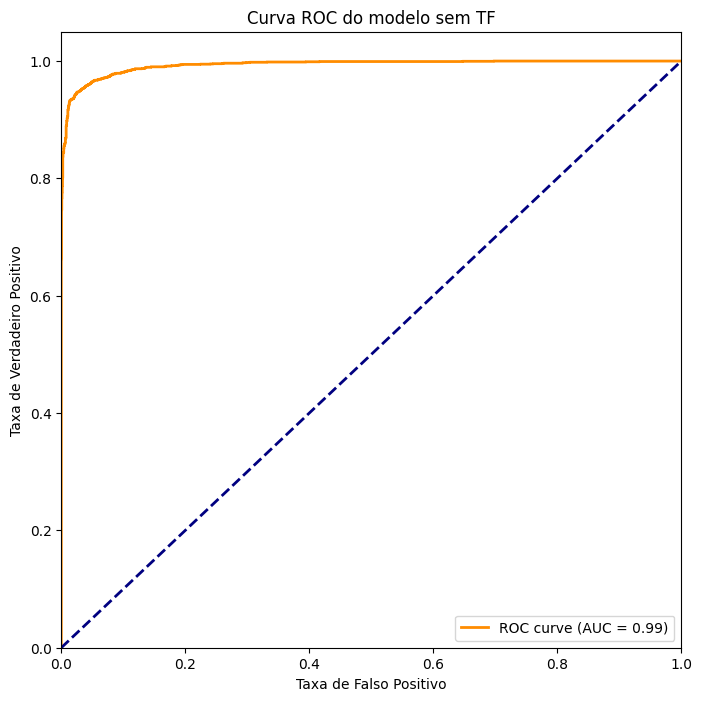

In [ ]:
plot_auc(model, False)
plot_auc(model_new, True)

## Bônus 1 - Baixando localmente os modelos gerados
Abaixo, há um código que você pode usar se rodou os códigos e quiser usar os modelos e seu conhecimento para alguma tarefa ou análise futura.

In [ ]:
import shutil
caminho_do_modelo = "/modelo_puro_treinado"
model.save(caminho_do_modelo)

caminho_do_novo_modelo = "/modelo_TF"
model_new.save(caminho_do_novo_modelo)

shutil.make_archive("/modelo_puro_treinado", 'zip', "/modelo_puro_treinado")
files.download("/modelo_puro_treinado.zip")

shutil.make_archive("/modelo_TF", 'zip', "/modelo_TF")
files.download("/modelo_TF.zip")

## Bônus 2 - Enviando suas próprias imagens para o modelo avaliar
Abaixo, há um código que te permite fazer o upload se uma imagem qualquer e ter suas classificação resultante.

In [ ]:
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # Classificando imagem
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])

  #Mude para model_new se quiser o modelo com transfer learning
  classes = model.predict(images, batch_size=10)

  if classes[0]>0.5:
    print(fn + " é um cachorro")
  else:
    print(fn + " é um gato")